# <font color='darkblue'>Sparkify Small Dataset Analysis</font>

<div class="alert alert-block alert-warning">

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

- [ ] Review Bike Project
- [ ] explore: look at rows
- [X] print schema & meaning of each column & datatype
- [X] describe: stats for numerical columns
- [X] describe one column at a time
- [ ] crosstab computations - 2 columns stats
- [X] count entries of certain type
- [ ] look at data with condition on some row: select
- [ ] filter data
- [ ] calculate statistics per hour
- [X] visiting frequencies per day and week vs weekend
- [ ] average time spent per session
- [X] investigate missing values
- [ ] drop rows with missing values
- [X] word cloud for song names
- [ ] investigate unusual records in each column
- [ ] drop columns
- [ ] rename columns
- [X] timestamp
- [ ] binarize or change categorical columns
- [ ] percentage of time spent on different page types
- [ ] find when users downgrade the accounts and flag those entries
- [X] which page did user "" did not visit
- [X] how many M/F are in the dataset
- [ ] how many artists in dataset
- [ ] how many songs in dataset
- [ ] how many songs played from the most played artist
- [ ] how many songs do users listen on average between visiting home page
- [ ] whether the user has paid or not
- [ ] time user stay after advertisment
- [X] simple stats
- [ ] daily listening times: for the average user, how long is the average sparkify user actually listening to music per day
- [ ] number songs per day, including any repeat or partial listens, for the average user
- [ ] core metrics
- [ ] monthly active users: number the unique users who listened to at least one song in the past month
- [ ] daily active users for each day in the past month, both the total number and the percentage of the monthly active users - daily actives help understand how engaged the users are
- [X] calculate the total number of paid and unpaid users
- [ ] total ads served in the past month
- [ ] build data preprocessing pipeline
- [ ] approach how users interact with service over time
- [ ] Cohort analysis: the main idea is that someone who joined Sparkify a year ago probably behaves differently than a brand new user, so we analyze them in separate groups which we call cohorts Jan 10, Dec 17, etc
</div>

In [1]:
# import neccessary libraries and packages

import datetime

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from wordcloud import (
    WordCloud,
    ImageColorGenerator,
    )
import stylecloud

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    col, desc, asc,
    count, countDistinct, 
    when, lit,  
    isnull, isnan,
    from_unixtime, dayofmonth, month, hour, date_format,
    lag, lead,
    first, last, split,
    )

#import pyspark.sql.functions as F

In [3]:
%%capture --no-display

# create a Spark session

spark = SparkSession \
        .builder \
        .appName("Wrangling Mini Data") \
        .getOrCreate()

## <font color='blue'>Load the Dataset</font>

In this notebook, we will work with a mini-dataset, a sample of about 128 MB of the entire Sparkify dataset (of about 12 GB of data). 

In [4]:
path = "data/mini_sparkify_event_data.json"
df = spark.read.json(path)

## <font color='blue'>Analyze the Data</font>

In [5]:
# count the number of rows
print("\nThere are {} records in the dataset.\n".format(df.count()))
# count the number of columns
print("The dataset has {} columns or features.\n".format(len(df.columns)))


There are 286500 records in the dataset.

The dataset has 18 columns or features.



In [6]:
# peek at the data 
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [7]:
# one more peek at the data
df.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

### <font color='blue'>Print Schema and Investigate the Features</font>

In [8]:
# print and investigate the structure of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# check for null values
df.select([count(when(isnan(c) | col(c).isNull(), c)) \
           .alias(c) for c in df.columns]) \
           .show(vertical=True)

-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     



In [10]:
# count distinct entries in each column
df.select([countDistinct(c) \
           .alias(c) for c in df.columns]) \
           .show(vertical=True)

-RECORD 0---------------
 artist        | 17655  
 auth          | 4      
 firstName     | 189    
 gender        | 2      
 itemInSession | 1322   
 lastName      | 173    
 length        | 14865  
 level         | 2      
 location      | 114    
 method        | 2      
 page          | 22     
 registration  | 225    
 sessionId     | 2354   
 song          | 58480  
 status        | 3      
 ts            | 277447 
 userAgent     | 56     
 userId        | 226    



### <font color='blue'>Feature Descriptions and Data Types</font>


|Information| Column | DType | Brief Description |
| --------- | :----- | :---- | :---------------- |
| user-info| userId | string | unique identifier of the user|
| user-info | firstName | string | user's first name |
| user-info | lastName | string | user's last name |
| user-info | gender | string | user's gender, values: _F_, _M_ |
| user-info | location | string | user's location |
| user-info | userAgent | string | information on the browser used by the user |
| user-info | level | string | subscription level, values: _free_, _paid_ |
| user-info | registration | bigint | user's registration timestamp |
|           |              |                                        |
| song-info | artist | string | artist's name the song is by |
| song-info | song | string | song's name |
| song-info | length | double | song's length in seconds |
|           |        |        |                          |
| log-info | auth | string | authentication: _Logged In_, _Logged Out_, _Cancelled_, _Guest_|
| log-info | itemInSession | bigint | number of logs in the session |
| log-info | method | string | HTTP request method, values: _GET_, _PUT_ |
| log-info | page | string | type of action, 22 values: _Home_, _About_, _NextSong_, etc. |
| log-info | sessionId | bigint | session id|
| log-info | status | bigint | HTTP status code: values _200_, _404_, _307_ |
| log-info | ts | bigint | timestamp of the log event |


### <font color='blue'>userId Column</font>

In [11]:
# the number of distinct userId stored in the dataset 
df.select(countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [12]:
# count rows by userId 
userId_counts = df.groupBy("userId").count().orderBy("userId")
userId_counts.show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [13]:
# there are records with empty userId
userId_counts.show(1)

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+
only showing top 1 row



In [14]:
# investigate the entries with " " userId
blank_users = df.filter(df.userId == "")
blank_users.show(4)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [15]:
# count the unique entries in blank_users
blank_users.select([countDistinct(c) \
           .alias(c) for c in blank_users.columns]) \
           .show(vertical=True)

-RECORD 0-------------
 artist        | 0    
 auth          | 2    
 firstName     | 0    
 gender        | 0    
 itemInSession | 565  
 lastName      | 0    
 length        | 0    
 level         | 2    
 location      | 0    
 method        | 2    
 page          | 7    
 registration  | 0    
 sessionId     | 1629 
 song          | 0    
 status        | 3    
 ts            | 8305 
 userAgent     | 0    
 userId        | 1    



In [16]:
# take a look at the empty userId that are paid users
blank_paid = blank_users.filter(blank_users.level == "paid")
blank_paid.show(4)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|           49|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538381499000|     null|      |
|  null|Logged Out|     null|  null|           50|    null|  null| paid|    null|   PUT|Login|        null|      141|null|   307|1538381500000|     null|      |
|  null|Logged Out|     null|  null|           57|    null|  null| paid|    null|   GET| Home|        null|      141|null|   200|1538382349000|     null|      |
|  null|Logged Out|     null|  nul

In [17]:
# the empty userId, paid are 'Logged Out' users
blank_paid.groupBy("auth").count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 5729|
+----------+-----+



In [18]:
# take a look at the empty userId that are free users
blank_free = blank_users.filter(blank_users.level == "free")
blank_free.show(4)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [19]:
# most of the empty userId, that use free tier are also 'Logged Out' users
blank_free.groupBy("auth").count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 2520|
|     Guest|   97|
+----------+-----+



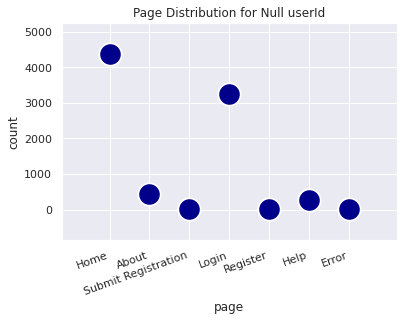

In [20]:
# plot the page usage distribution for null userId

# create the count dataframe
blank_users_page = blank_users.groupby("page").count().toPandas()

# create the figure and title
sns.set(rc = {"figure.figsize":(6,4)})
sns.set(font_scale=1)

sns.scatterplot(x="page", y="count", 
                data=blank_users_page, 
                color="darkblue", s=500)

plt.title("Page Distribution for Null userId")
plt.xticks(rotation=20, horizontalalignment="right")

# pad margins so that markers don't get clipped by the axes
plt.margins(0.2)

plt.show()

<div class="alert alert-block alert-info">
    
There are 8346 rows where _userId_ is the empty string. Out of these, 5729  correspond to logged out paid users. The remaining 2617 records correspond to users that are not registered, that also logged out or they are logged in as _Guest_.
 
We shall drop the records that have empty _userId_.
</div>

### <font color='blue'>firstName, lastName Columns</font>

In [21]:
# take a look of the format of the two columns
df.select("firstName", "lastName").show(4)

+---------+--------+
|firstName|lastName|
+---------+--------+
|    Colin| Freeman|
|    Micah|    Long|
|    Colin| Freeman|
|    Micah|    Long|
+---------+--------+
only showing top 4 rows



In [22]:
# take a look at the user activity
df.groupBy(["userId","firstName", "lastName"]).count().show(10)

+------+---------+--------+-----+
|userId|firstName|lastName|count|
+------+---------+--------+-----+
|   123|    Chloe|   Myers|  196|
|300018|   Joseph|   Green| 2046|
|    66|   Alyssa|Johnston| 1288|
|100009|     Troy|  Mathis|  671|
|    29|    Kaleb|Thompson| 3603|
|   133|     Liam| Fleming|   44|
|   155|   Camila|Calderon| 1002|
|   132|    Sadie|   Jones| 2304|
|    56|  Greysen| Jackson|  955|
|    82|   Peyton| Stewart| 2049|
+------+---------+--------+-----+
only showing top 10 rows



### <font color='blue'>gender Column</font>

In [23]:
# the entries in gender column indicate user's gender
df.groupBy("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



In [24]:
# gender data counts and percentages, excludes null values

df_gender = df \
            .filter(col("gender").isNotNull()) \
            .groupby('gender') \
            .agg((count('gender')) \
            .alias('count'),
                 (Fround(count('gender') / df.count(), 2)*100) \
                 .alias('percentage'))
df_gender.show()

+------+------+----------+
|gender| count|percentage|
+------+------+----------+
|     F|154578|      54.0|
|     M|123576|      43.0|
+------+------+----------+



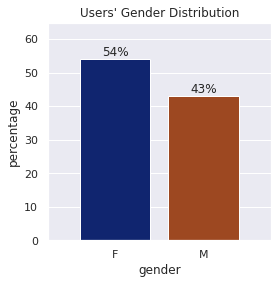

In [25]:
# barplot for gender distribution

# set size and font
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# create the plot
ax = sns.barplot(x='gender', y="percentage", 
                 data=df_gender.toPandas(), palette="dark")

# create labels
ax.bar_label(ax.containers[0], fmt='%.f%%');

# pad margins so that markers don't get clipped by the axes
plt.margins(0.2)

# create title
plt.title("Users' Gender Distribution");

### <font color='blue'>location Column</font>

In [117]:
# take a look at sample location records
df.select(["location"]).show(6, truncate=False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
+------------------------------+
only showing top 6 rows



In [27]:
df = df.withColumn("city", split(df["location"], ",").getItem(0)) \
        .withColumn("state", split(df["location"], ",").getItem(1))

df.show(1, truncate=True, vertical=True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
 city          | Bakersfield          
 state         |  CA                  
only showing top 1 row



In [28]:
# drop the initial location column and check the outcome
df.drop(df.location).printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



In [29]:
# take a look at the distribution of sessions by state
df.groupBy("state").count().show()

+------------+-----+
|       state|count|
+------------+-----+
|       NE-IA|  187|
|       PA-NJ|  815|
|          WA| 3772|
| DC-VA-MD-WV| 3090|
|          AL| 2857|
|          MI| 7216|
|       MN-WI| 2241|
|    IL-IN-WI| 5114|
|        null| 8346|
|       MD-WV|  982|
|          NH| 4764|
|          AK| 3563|
|          AR|  520|
|          AZ| 4846|
|       MA-NH|13873|
|          WV| 2278|
|    TN-MS-AR|   62|
|       MO-IL| 4858|
|          TN| 1672|
|          NY| 4536|
+------------+-----+
only showing top 20 rows



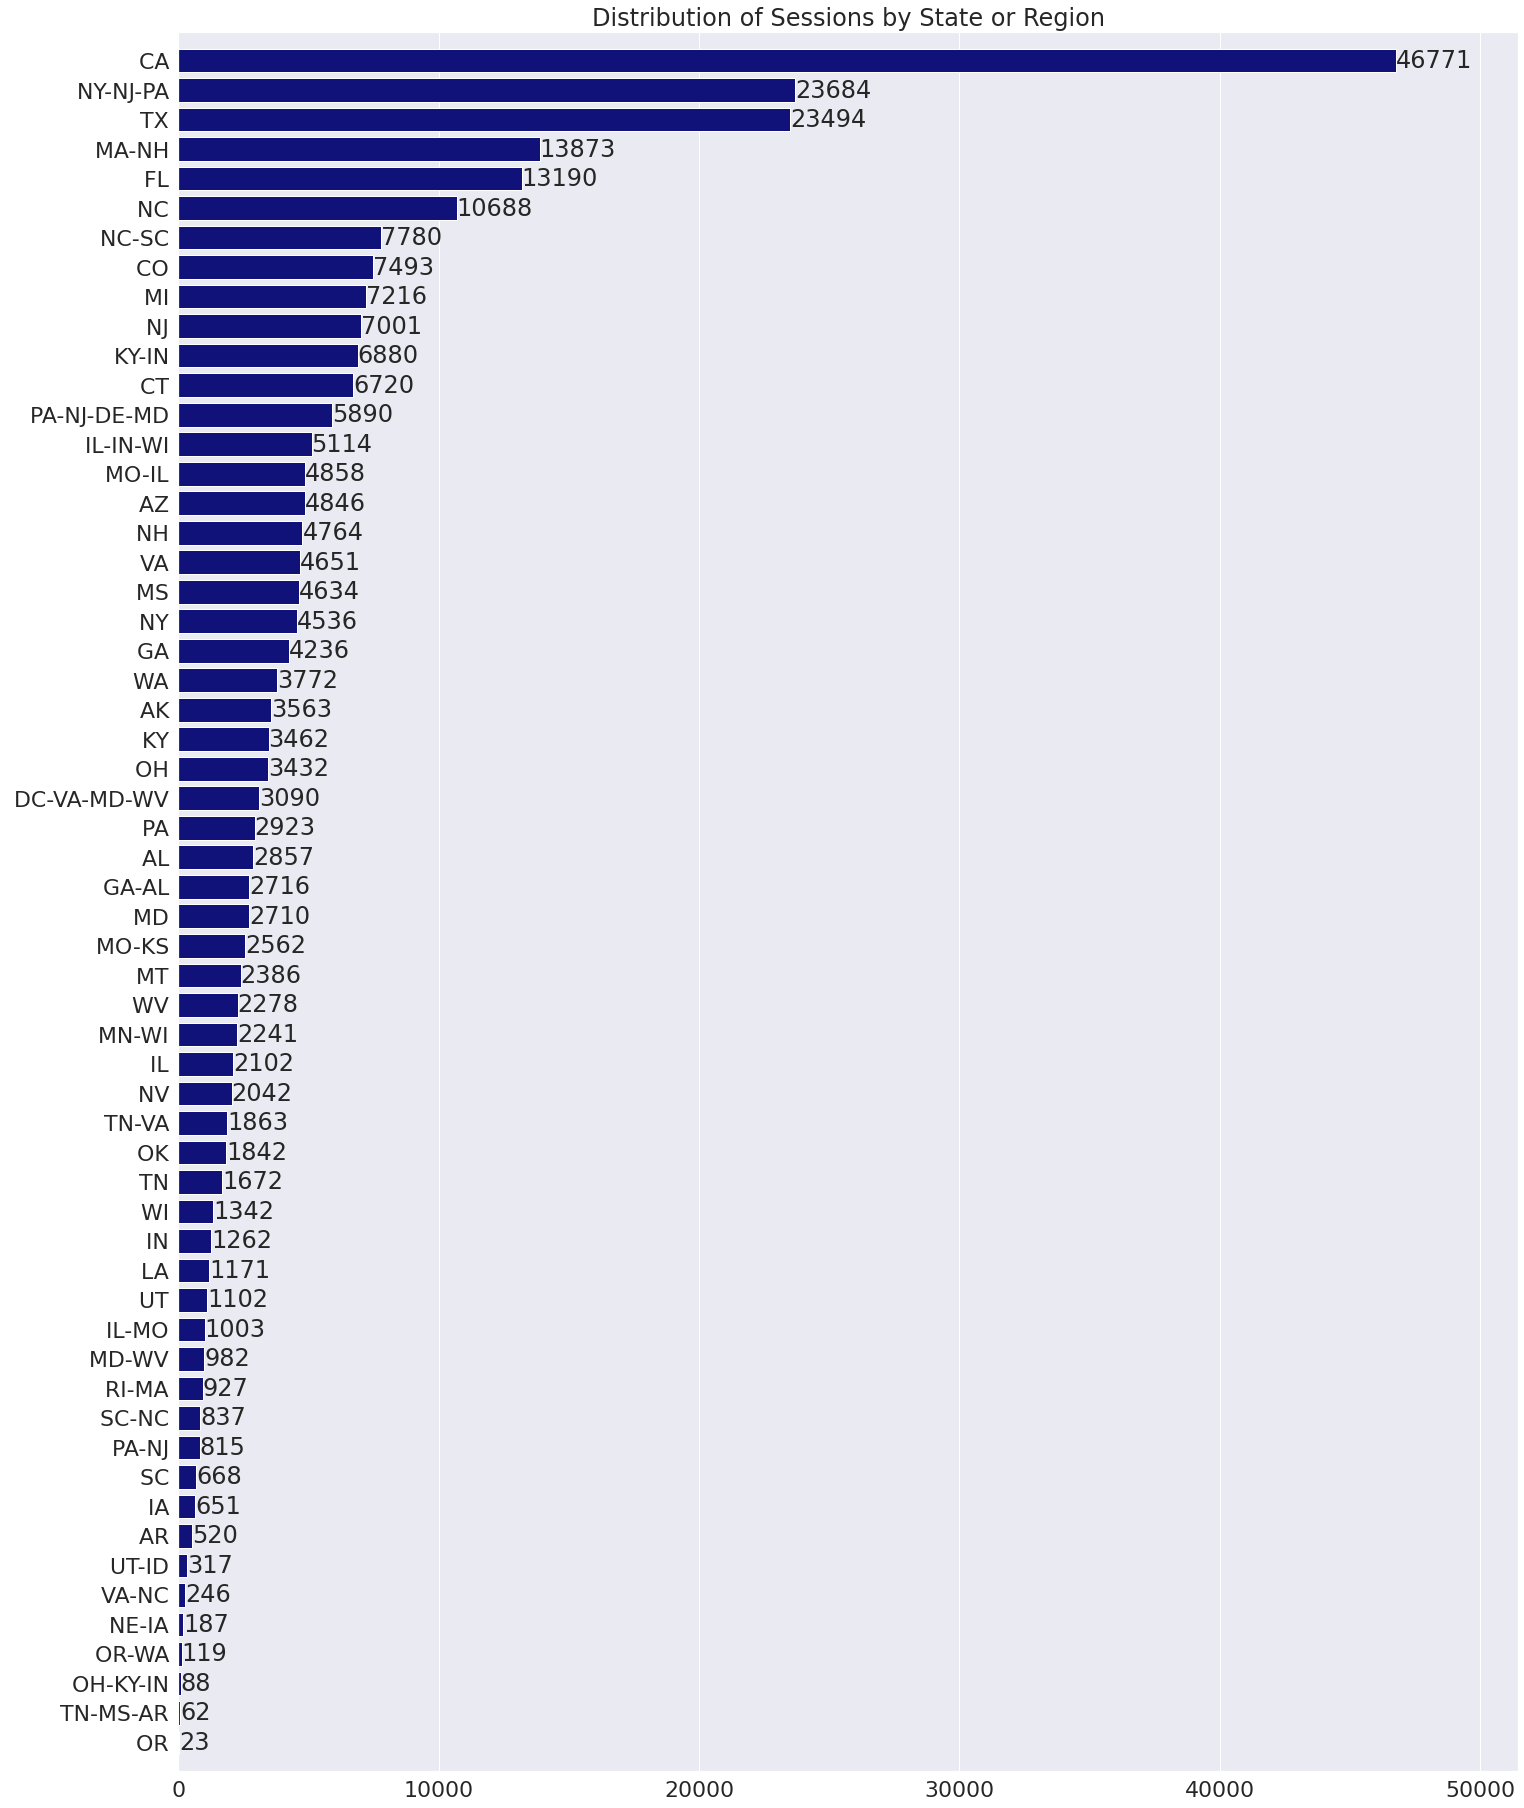

In [30]:
# visualize the distribution of sessions by state

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(24,32)})
sns.set(font_scale=2)

# plot the distribution by state
ax = sns.countplot(y="state", data=df.toPandas(),
                  order = df.toPandas()["state"] \
                   .value_counts().index,
                  color="darkblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.1, y=0.01, tight=True)

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.title("Distribution of Sessions by State or Region");

In [31]:
# count the users by state

user_by_state = df.groupBy(["state"]).agg(countDistinct("userId"))
user_by_state.show(4)

+------------+-------------+
|       state|count(userId)|
+------------+-------------+
|       NE-IA|            1|
|       PA-NJ|            1|
|          WA|            4|
| DC-VA-MD-WV|            4|
+------------+-------------+
only showing top 4 rows



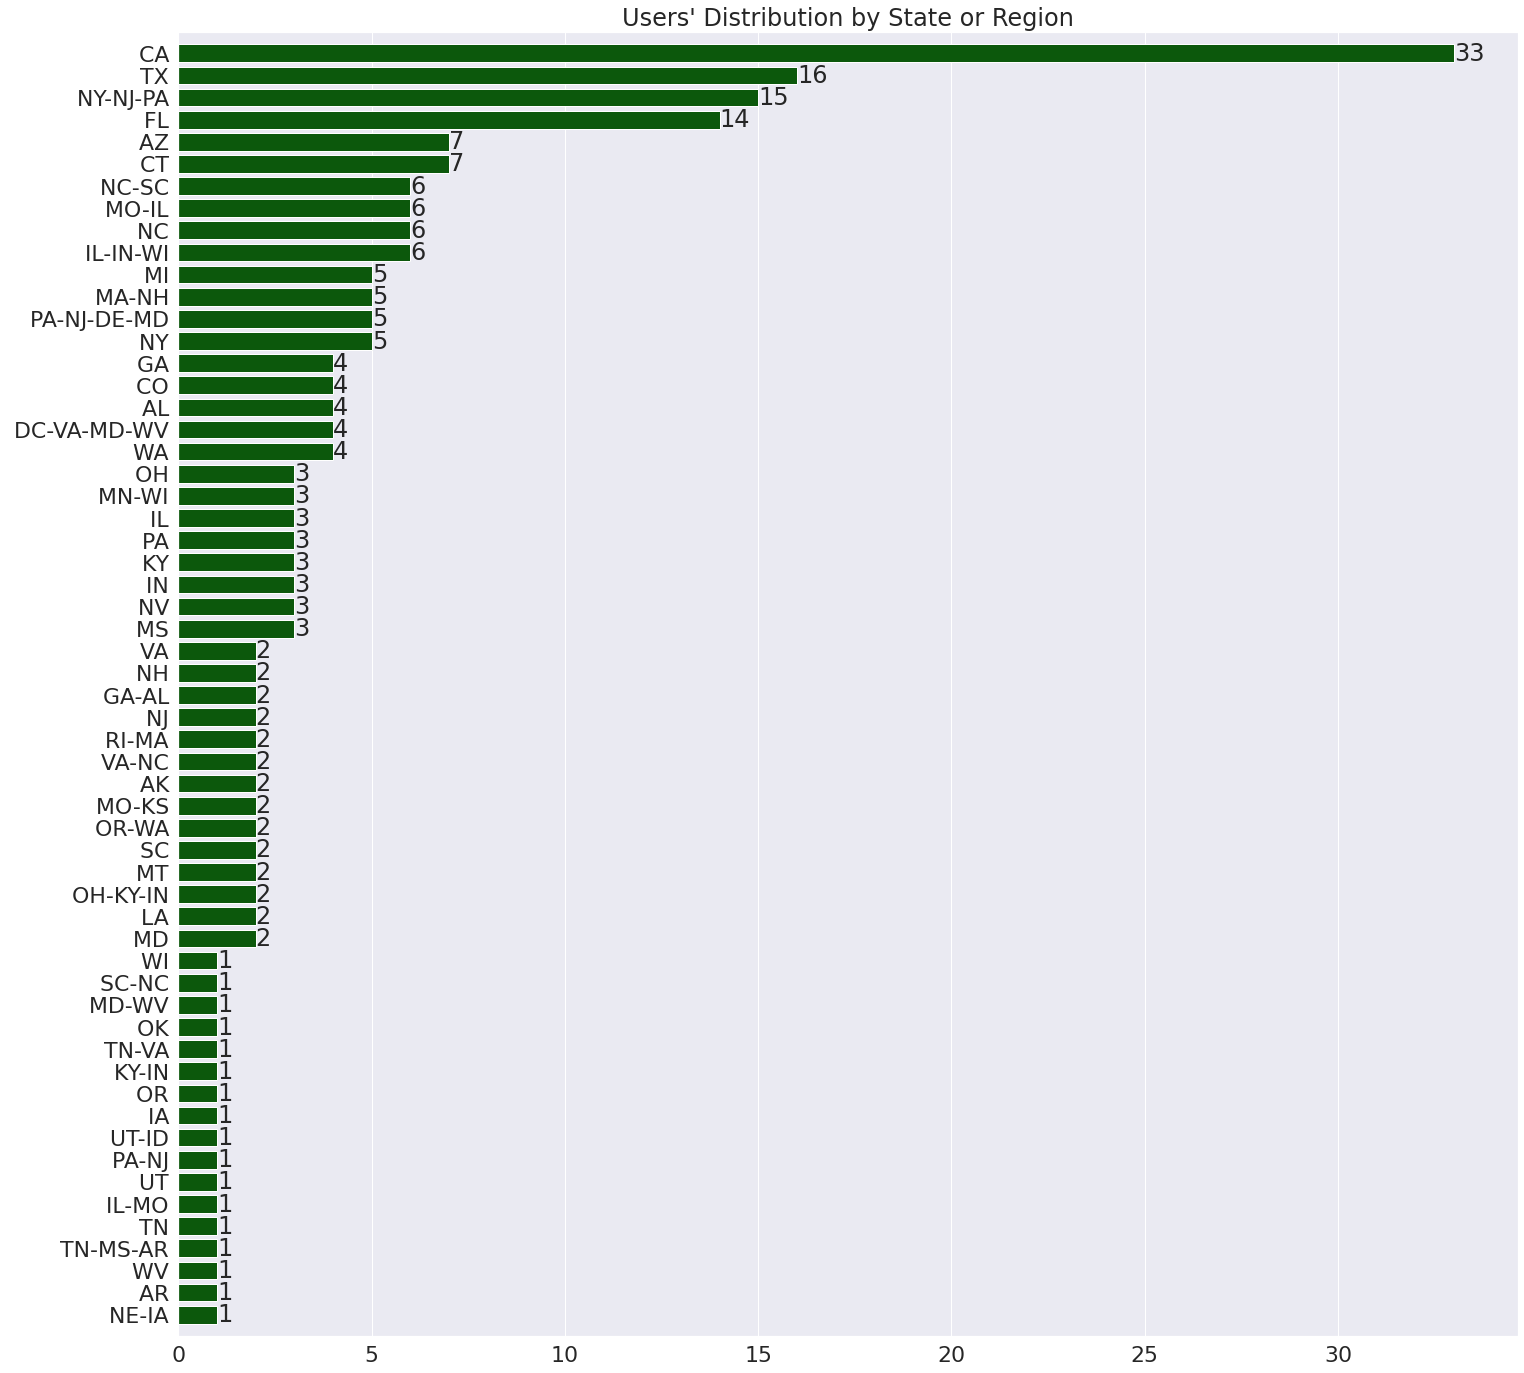

In [32]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(24,24)})
sns.set(font_scale=2)

data = user_by_state.toPandas().sort_values(by="count(userId)",ascending=False)

# plot the distribution of users by state
ax = sns.barplot(y="state", x = "count(userId)", data=data,
                  color="darkgreen")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.05, y=0.01, tight=True)

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.title("Users' Distribution by State or Region");

<div class="alert alert-block alert-info">
The users' records are from 58 states and regions (groups of 2-3 states). The distribution of the users among these states is very uneven, with CA having the largest number of users (33), most of the other states have less than 10 users.
</div>

### <font color='blue'>userAgent Column</font>

In [33]:
# peek at the userAgent entries available in the dataset
df.groupBy("userAgent").count().show(4, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                 |count|
+--------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|240  |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |5238 |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |62   |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|18448|
+----------------------------------------------------------------------------------

In [34]:
# userAgent groupped by userId
df_userAgent = df \
    .groupBy(["userAgent"]) \
    .agg(countDistinct("userId")) \
    .sort(["count(userId)"], ascending=False)
df_userAgent.show(10,truncate=True)

+--------------------+-------------+
|           userAgent|count(userId)|
+--------------------+-------------+
|"Mozilla/5.0 (Win...|           24|
|Mozilla/5.0 (Wind...|           18|
|"Mozilla/5.0 (Mac...|           16|
|"Mozilla/5.0 (Mac...|           12|
|"Mozilla/5.0 (Mac...|           12|
|"Mozilla/5.0 (Win...|           10|
|"Mozilla/5.0 (Mac...|           10|
|Mozilla/5.0 (Maci...|            9|
|"Mozilla/5.0 (iPh...|            8|
|"Mozilla/5.0 (Mac...|            7|
+--------------------+-------------+
only showing top 10 rows



<div class="alert alert-block alert-info">

<li> The User-Agent request header is a characteristic string that lets servers and network peers identify the application, operating system, vendor, and/or version of the requesting user agent. 
</li>

<li>The common format for web browsers is:

    Mozilla/5.0 (<system-information>)<platform> (<platform-details>) <extensions>
    
 </li>
    
<li>Syntax and common format for the most popular web browsers can be found <a href="https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent"><b>here</b></a>.
    </li>
    
<li>There are 56 user-agents available in the dataset, the specifics of each entry can be identified using this <a href="http://www.browser-info.net/useragentl"><b>webapp</b></a>.
    </li>

<li>For example: <i>Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)</i> corresponds to Microsoft Internet Explorer 9.0 on a Windows 7.
    </li>
    
</div>

### <font color='blue'>level Column</font>

In [36]:
# level counts and percentages, to distinguish between paid and free tier

df_level = df \
            .filter(col("level").isNotNull()) \
            .groupby("level") \
            .agg((count("level")) \
            .alias("count"),
                 (Fround(count("level") / df.count(), 2)*100) \
                 .alias("percentage"))

df_level.show()

+-----+------+----------+
|level| count|percentage|
+-----+------+----------+
| free| 58338|      20.0|
| paid|228162|      80.0|
+-----+------+----------+



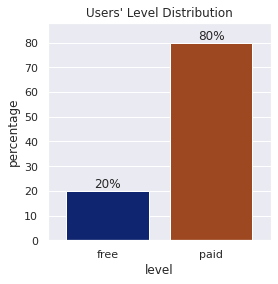

In [37]:
# barplot for level distribution

# set figure size and font scale
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# create the plot
ax = sns.barplot(x="level", y="percentage", 
                 data=df_level.toPandas(), palette="dark")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.1, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0], fmt='%.f%%');
plt.title("Users' Level Distribution");

### <font color='blue'>registration, ts Columns</font>

In [38]:
# convert the timestamp in registration and ts into datetime format
df = df.withColumn("date_ts", from_unixtime(col("ts")/1000.0))
df = df.withColumn("date_reg", from_unixtime(col("registration")/1000.0))
# check the output
df.show(4)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|   

In [39]:
# extract day of the month in a separate column
df = df.withColumn("day_ts", dayofmonth(df.date_ts))
df = df.withColumn("day_reg", dayofmonth(df.date_reg))
# check the output
df.show(4)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, C

In [40]:
# extract day of the week in words
df=df.withColumn("weekday_ts", date_format(col("date_ts"), "EEEE"))
df=df.withColumn("weekday_reg", date_format(col("date_reg"), "EEEE"))
# check the output
df.show(4)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+
|  Martha Tilston|Logged In|    Co

21/12/14 15:03:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [41]:
# extract month from date
df = df.withColumn("month_ts",month(df.date_ts))
df = df.withColumn("month_reg",month(df.date_reg))
# check the output
df.show(4)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+---------

In [42]:
# get session hour from timestamp
df = df.withColumn("hour_ts",hour(df.date_ts))
# check the output
df.show(4)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----

In [43]:
# take a look at the statistics for the two columns registration and ts
reg_ts = df.describe("registration", "ts")
reg_ts.show()

+-------+--------------------+--------------------+
|summary|        registration|                  ts|
+-------+--------------------+--------------------+
|  count|              278154|              286500|
|   mean|1.535358834085557...|1.540956889810471...|
| stddev|3.2913216163276587E9| 1.507543960823119E9|
|    min|       1521380675000|       1538352117000|
|    max|       1543247354000|       1543799476000|
+-------+--------------------+--------------------+



In [44]:
# the earliest and the latest sessions in the dataset
mindate = df.agg(Fmin("date_ts")).toPandas()
maxdate = df.agg(Fmax("date_ts")).toPandas()

# print the start date and the end date of the period in the dataset
print("The first session recorded is on {}.".format(mindate["min(date_ts)"][0]))
print("The last session recorded is on {}.".format(maxdate["max(date_ts)"][0]))

The first session recorded is on 2018-09-30 20:01:57.
The last session recorded is on 2018-12-02 20:11:16.


In [45]:
# the earliest and the latest user registration in the dataset
mindatereg = df.agg(Fmin("date_reg")).toPandas()
maxdatereg = df.agg(Fmax("date_reg")).toPandas()

# print the start date and the end date of the period for user registration
print("The first session recorded is on {}.".format(mindatereg["min(date_reg)"][0]))
print("The last session recorded is on {}.".format(maxdatereg["max(date_reg)"][0]))

The first session recorded is on 2018-03-18 09:44:35.
The last session recorded is on 2018-11-26 10:49:14.


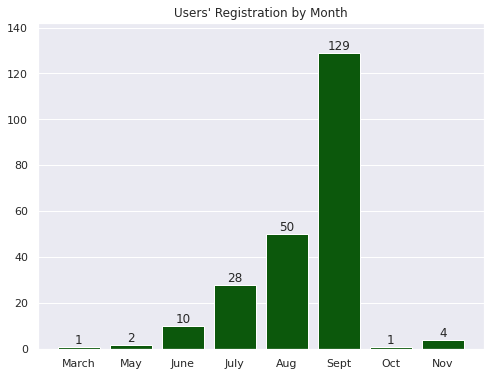

In [46]:
# visualize user registration by month

# count the users by the month they registered
reg_by_month = df.groupBy(["month_reg"]).agg(countDistinct("userId"))

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,6)})
sns.set(font_scale=1)

# create plot
data = reg_by_month.toPandas().sort_values(by="count(userId)",ascending=False)
months = ["March", "May", "June", "July", "Aug", "Sept", "Oct", "Nov"]

# plot the distribution of users by state
ax = sns.barplot(x="month_reg", y="count(userId)", data=data,
                  color="darkgreen")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.05, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
ax.set_xticklabels(months)  
plt.title("Users' Registration by Month");

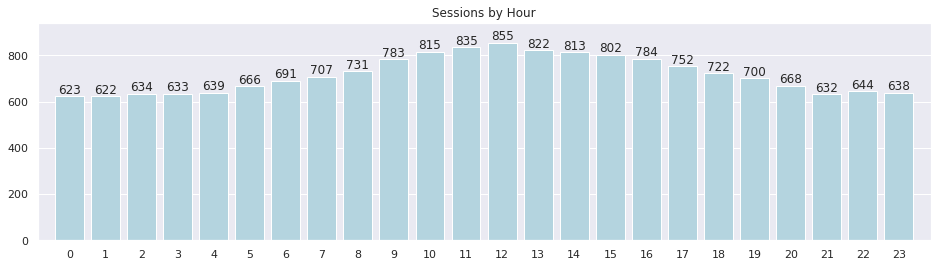

In [47]:
# visualize sessions by hour

# count sessions by hour
session_by_hour = df.groupBy(["hour_ts"]).agg(countDistinct("sessionId"))

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,4)})
sns.set(font_scale=1)

data = session_by_hour.toPandas().sort_values(by="count(sessionId)",ascending=False)

# plot the distribution of users by hour
ax = sns.barplot(x="hour_ts", y="count(sessionId)", data=data,
                  color="lightblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.title("Sessions by Hour");

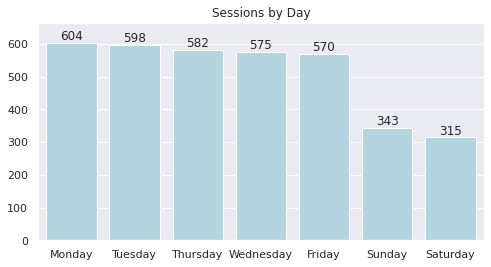

In [48]:
# visualize sessions by day of the week

# count sessions by day of the week
session_by_weekday = df.groupBy(["weekday_ts"]).agg(countDistinct("sessionId"))

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,4)})
sns.set(font_scale=1)

data = session_by_weekday.toPandas().sort_values(by="count(sessionId)",ascending=False)

# plot the distribution of users by day of the week
ax = sns.barplot(x="weekday_ts", y="count(sessionId)", data=data,
                  color="lightblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.title("Sessions by Day");

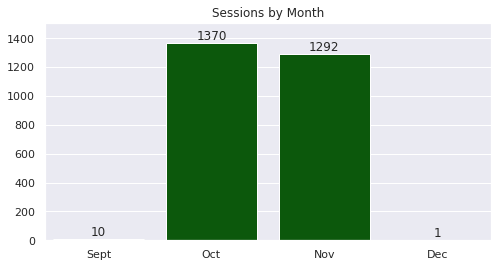

In [49]:
# visualize sessions by month

# count sessions by month
session_by_month = df.groupBy(["month_ts"]).agg(countDistinct("sessionId"))

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,4)})
sns.set(font_scale=1)

data = session_by_month.toPandas().sort_values(by="count(sessionId)",ascending=False)
month = ["Sept", "Oct", "Nov", "Dec"]

# plot the distribution of users by state
ax = sns.barplot(x="month_ts", y="count(sessionId)", data=data,
                  color="darkgreen")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
ax.set(xlabel=None)
ax.set_xticklabels(month)  
plt.title("Sessions by Month");

<div class="alert alert-block alert-info">
    
<a href="https://en.wikipedia.org/wiki/Unix_time">Unix time</a>  is also known as Epoch time which specifies the moment in time since 1970-01-01 00:00:00 UTC. It is the number of seconds passed since Epoch time. Epoch time is widely used in Unix like operating systems.

Both columns correspond to timestamps given miliseconds in Unix time, the _registration_ for the date and time when the user registered with the platform while _ts_ corresponds to the session timestamp.
    
After converting the data in _registration_ and _ts_, we learn that the dataset is based on users that registered in 2018 between March and November, with a sharp increase in registrations in September. The sessions are also from 2018, mostly from October and November. 
    
We also learn that the most popular listening times are around noon, and that the users listen more during the week days than on the wekend.

</div>

### <font color='blue'>method Column</font>

<div class="alert alert-block alert-info">

The Hypertext Transfer Protocol (HTTP) is designed to enable communications between clients and servers. HTTP works as a request-response protocol between a client and server. _GET_ is used to request data from a specified resource. _PUT_ is used to send data to a server to create/update a resource; see <a href="https://www.w3schools.com/tags/ref_httpmethods.asp"> HTTP Request Forms</a>.

</div>

In [51]:
# the HTTP request method initiated by user, counts and percentages 
df_method = df.groupBy("method").count()
df_method.show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



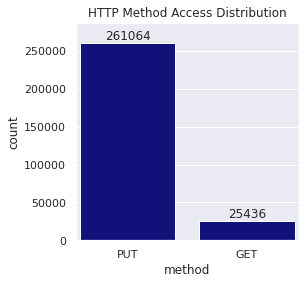

In [55]:
# visualize the distribution of sessions by method 

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the distribution of users by state
ax = sns.barplot(x="method", y="count", data=df_method.toPandas(),
                  color="darkblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
plt.title("HTTP Method Access Distribution");

### <font color='blue'>status Column</font>

<div class="alert alert-block alert-info">
    
The entries represent HTTP status codes. Three such codes can be found in this dataset:

- 200 - OK, the request has succeeded  
- 307 - temporary redirect
- 404 - not found

For a full list see: <a href ="https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html">HTTP Status Codes Definitions</a>.
    
</div>

In [57]:
# the HTTP request method initiated by user, counts and percentages 
df_status = df.groupBy("status").count()
df_method.show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



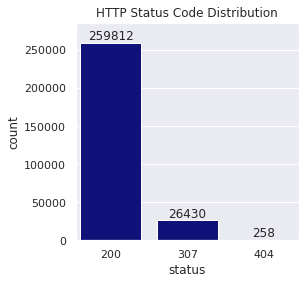

In [62]:
# visualize the distribution of sessions by method 

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the distribution of HTTP status by session 
ax = sns.barplot(x="status", y="count", data=df_status.toPandas(),
                  color="darkblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
plt.title("HTTP Status Code Distribution");

In [63]:
# take a look at the entries that have status 404
df_error = df.filter(df["status"] == 404)
df_error.show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|  null|Logged In|     Kael|     M|           48|

In [64]:
# a look at the other columns when status = 404
df_error.select([countDistinct(c) .alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0------------
 artist        | 0   
 auth          | 3   
 firstName     | 109 
 gender        | 2   
 itemInSession | 157 
 lastName      | 92  
 length        | 0   
 level         | 2   
 location      | 75  
 method        | 1   
 page          | 1   
 registration  | 117 
 sessionId     | 230 
 song          | 0   
 status        | 1   
 ts            | 258 
 userAgent     | 44  
 userId        | 118 
 city          | 74  
 state         | 45  
 date_ts       | 258 
 date_reg      | 117 
 day_ts        | 31  
 day_reg       | 29  
 weekday_ts    | 7   
 weekday_reg   | 7   
 month_ts      | 2   
 month_reg     | 8   
 hour_ts       | 24  



In [65]:
# determine how many records have status 404
print("There are {} records where the HTTP status is 404, page not found.".format(df_error.count()))

There are 258 records where the HTTP status is 404, page not found.


In [80]:
# take a look at the paid customers that have status 404
df_error_paid = df_error_paid.filter(df["level"] == "paid")
df_error_paid.show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|  null|Logged In|     Kael|     M|           48|

In [95]:
# take a closer look at the sessions of a paid customer
df_error_paid.filter(df_error_paid["userId"]=="124").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+------------------+-----+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|              city|state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+------------------+-----+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|  null|Logged In|   Nicole|     F|          100|    Beck|

<div class="alert alert-block alert-info">
    
There are 258 rows in the data that have status 404, page no found. 
- All these records have _GET_ as HTTP method.
- Some paid customers, such as the _userId_=124 have multiple sessions where _status_ = 404.

Although there are only a handful of such errors in the sample dataset, we have to investigate them in the full dataset also. Having troubles in logging in is a possible reason for a paid customer to cancel the subscription. 
    
</div>

### <font color='blue'>auth Column</font>

In [89]:
# the entries in auth column indicate the activity type of the user
df_auth = df.groupBy("auth").count()
df_method.show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



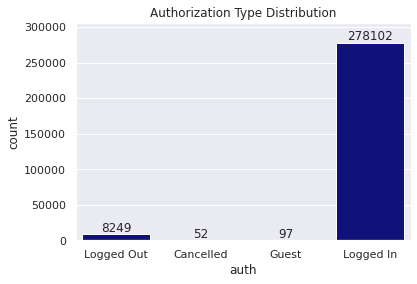

In [91]:
# visualize the distribution of the authorization type

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(6,4)})
sns.set(font_scale=1)

# plot the distribution of HTTP status by session 
ax = sns.barplot(x="auth", y="count", data=df_auth.toPandas(),
                  color="darkblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);
plt.title("Authorization Type Distribution");

In [97]:
# take a look at the users that cancelled
df_cancelled = df.filter(df["auth"] == "Cancelled")
df_cancelled.show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|  n

### <font color='blue'>page Column</font>

In [98]:
# create a dataframe with unique distinct types of actions - pages
pages_collect = df.select("page") \
        .where(col("page").isNotNull()) \
        .distinct() \
        .collect()

# collect all the pages in a list
pages = []
print('\nThe following pages are available for the users:\n')
for row in pages_collect:
    # create a list of pages
    pages.append(str(row['page']))
    # print the page name
    print(str(row['page']))


The following pages are available for the users:

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Submit Registration
Settings
Login
Register
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade


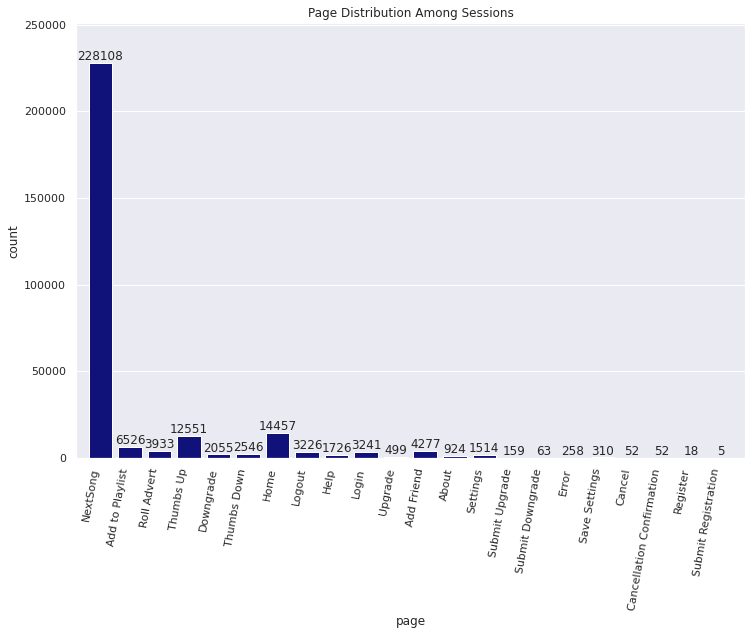

In [103]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,8)})
sns.set(font_scale=1)

# plot the page distribution 
ax = sns.countplot(x="page", data=df.toPandas(),
                  color="darkblue")

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and title
ax.bar_label(ax.containers[0]);

plt.xticks(rotation=80, horizontalalignment="right");
plt.title("Page Distribution Among Sessions");

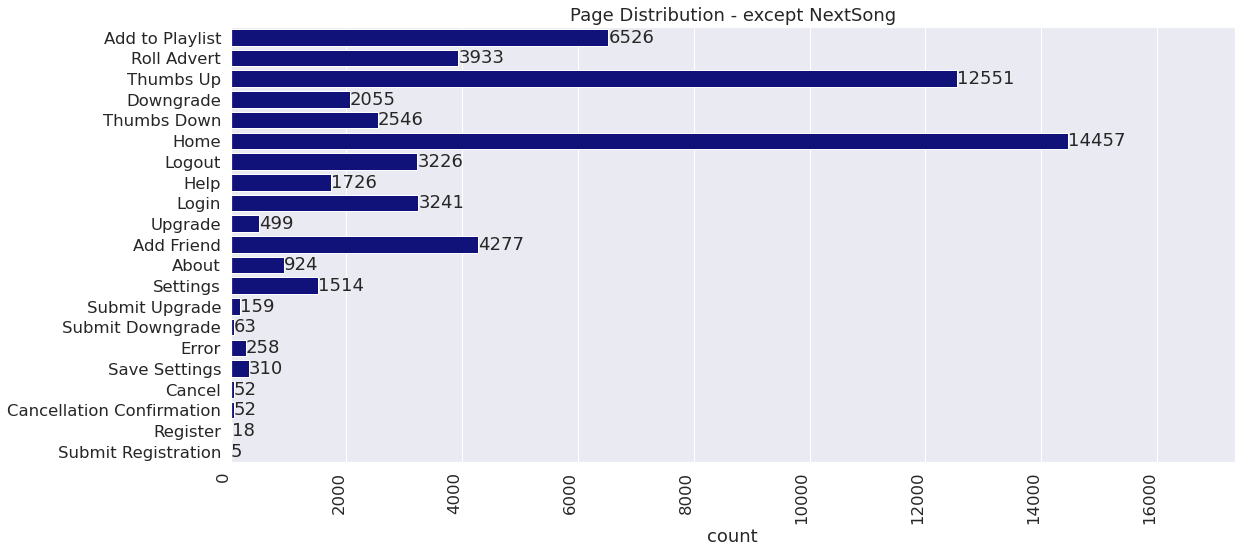

In [111]:
# plot the pages other than NextSong
df_pages = df.filter(df["page"] != "NextSong")

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(18,8)})
sns.set(font_scale=1.5)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.4, tight=True);

# plot the page distribution
ax = sns.countplot(y="page", data=df_pages.toPandas(), color="darkblue")
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None)
plt.xticks(rotation=90, horizontalalignment='right');
ax.set_title("Page Distribution - except NextSong");

In [116]:
# most of the actions are on NextSong, then Home and ThumbsUp
df.groupBy("page").count().sort(desc("count")).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|Cancellation Conf...|    52|
|              Cancel|    52|
+--------------------+------+
only showing top 20 rows



### <font color='blue'>song, artist Columns</font>

In [118]:
# function from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

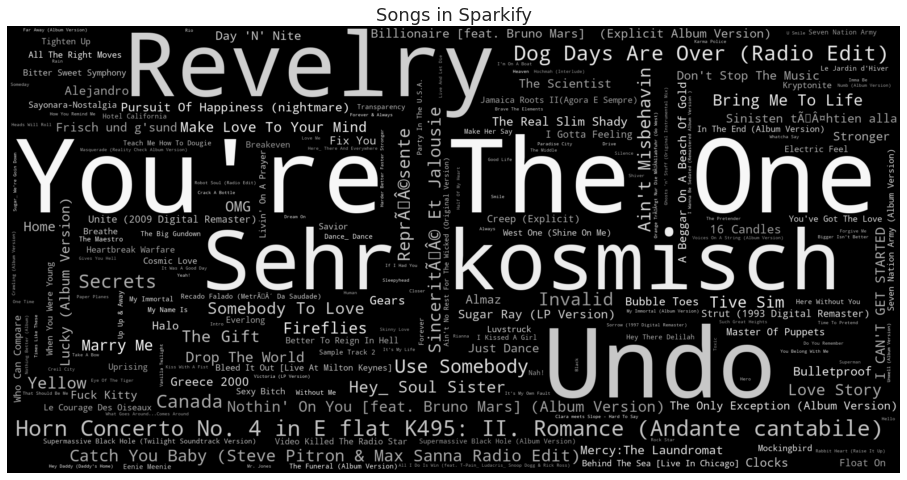

In [119]:
# create a simple wordcloud with the song titles
songs_df = df.toPandas()["song"].value_counts().to_dict()

# create the figure and title
plt.figure(figsize=(16, 10))

# generate the wordcloud from frequencies
wc = WordCloud(width = 2000, 
               height=1000, 
               margin=10, 
               random_state=1).generate_from_frequencies(songs_df)

# display the fitted and recolored wordcloud
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")

# turn axis off to get rid of axis numbers
plt.axis("off")

# create title
plt.title("Songs in Sparkify")

# save to file
wc.to_file("sparkify_songs.png")

plt.show()


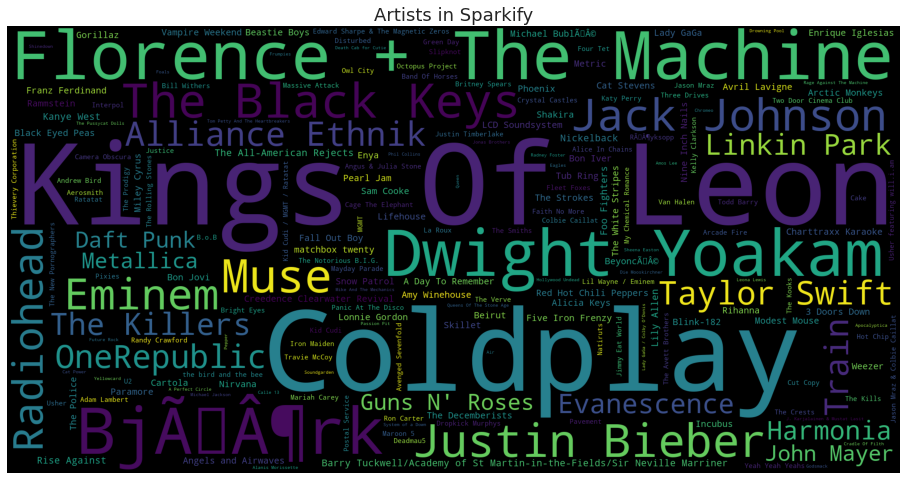

In [120]:
# create a simple wordcloud with artist names
artists_df = df.toPandas()["artist"].value_counts().to_dict()

# create the figure and title
plt.figure(figsize=(16, 10))

# generate the wordcloud from frequencies
wc = WordCloud(width = 2000, 
               height=1000, 
               margin=10, 
               random_state=1).generate_from_frequencies(artists_df)

# display the fitted wordcloud
plt.imshow(wc)

# turn axis off to get rid of axis numbers
plt.axis("off")

# create title
plt.title("Artists in Sparkify")

# save to file
wc.to_file("sparkify_artists.png")

plt.show()

In [130]:
# take a look at the rows with missing song information
df.filter(df.song.isNull()).show(4)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|                city| state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+--------------------+------+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|  null|Logged In| 

### <font color='blue'>length Column</font>

It represents the length of a song, in seconds.

In [131]:
# print descriptive statistics for songs length
df.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783478|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



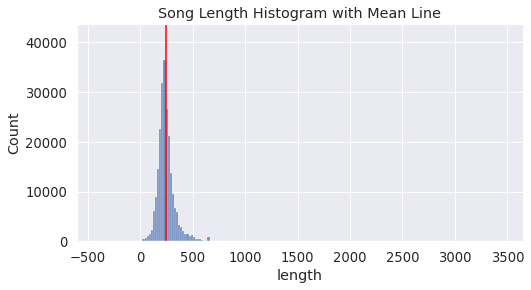

In [138]:
# plot the distribution of song lengths

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(8,4)})
sns.set(font_scale=1.2)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

sns.histplot(data=df.toPandas(), x="length", binwidth=20);

# create vertical line to indicate the mean
plt.axvline(x=df.toPandas().length.mean(), color='red');

# create title
plt.title("Song Length Histogram with Mean Line");


In [145]:
# count the number of songs longer than 1000 s (about 16 min)
df.filter(df["length"] > "1000").count()

282

### <font color='blue'>itemInSession Column</font>

In [62]:
# print descriptive statistics for itemInSession column
df.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141113|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [146]:
# create a dataframe for those data points with itemInSession=0
itemInSession_zero = df.filter(df['itemInSession'] == 0)
# find how many entries have itemInSession = 0
itemInSession_zero.count()

3278

In [147]:
# take a look at some of the data with 0 logs in session
itemInSession_zero.show(4)

+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-----+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|           artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|                city|state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-----+-------------------+-------------------+------+-------+-

In [151]:
# check for null values for the zero itemInSession rows
itemInSession_zero.select([count(when(isnan(c) | col(c).isNull(), c)) \
           .alias(c) for c in itemInSession_zero.columns]) \
           .show(vertical=True)

-RECORD 0-------------
 artist        | 1586 
 auth          | 0    
 firstName     | 589  
 gender        | 589  
 itemInSession | 0    
 lastName      | 589  
 length        | 1586 
 level         | 0    
 location      | 589  
 method        | 0    
 page          | 0    
 registration  | 589  
 sessionId     | 0    
 song          | 1586 
 status        | 0    
 ts            | 0    
 userAgent     | 589  
 userId        | 0    
 city          | 589  
 state         | 589  
 date_ts       | 0    
 date_reg      | 589  
 day_ts        | 0    
 day_reg       | 589  
 weekday_ts    | 0    
 weekday_reg   | 589  
 month_ts      | 0    
 month_reg     | 589  
 hour_ts       | 0    



In [154]:
itemInSession_zero.groupby("page").count().show()

+--------+-----+
|    page|count|
+--------+-----+
|    Home| 1352|
|   About|    6|
|   Login|  207|
|Register|    1|
|NextSong| 1692|
|    Help|   18|
|   Error|    2|
+--------+-----+



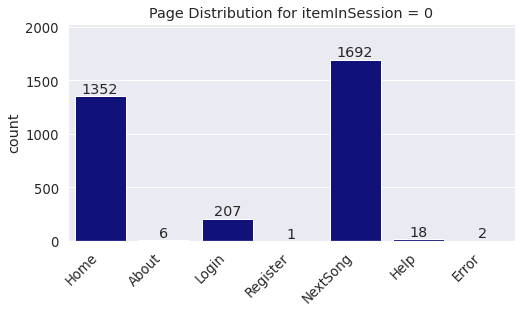

In [158]:
# plot the page usage distribution for zero itemInSession

# create the count dataframe
itemInSession_page = itemInSession_zero.groupby("page").count().toPandas()

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(8,4)})
sns.set(font_scale=1.2)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# create the plot
ax = sns.barplot(x="page", y="count", 
            data=itemInSession_page,
           color="darkblue")

# create labels and title
ax.bar_label(ax.containers[0]);
plt.title("Page Distribution for itemInSession = 0");
ax.set(xlabel = None)
plt.xticks(rotation=45, horizontalalignment='right');

### <font color='blue'>userId Column</font>

In [167]:
# the distribution of sessions by userId
df.groupby("userId").count().show(6)

+------+-----+
|userId|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
|     7|  201|
+------+-----+
only showing top 6 rows



In [165]:
# there are no null values in userId
df.where(col("userId").isNull()).count()

0

### <font color='blue'>One Customer At a Time</font>

In [166]:
# take a closer look at the sessions of a paid customer
df_124 = df.filter(df["userId"]=="124")
df_124.show(4)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------------------+-----+-------------------+-------------------+------+-------+----------+-----------+--------+---------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|              city|state|            date_ts|           date_reg|day_ts|day_reg|weekday_ts|weekday_reg|month_ts|month_reg|hour_ts|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------------------+-----+-------------------+-------------------+------+-------+-

In [168]:
# count distinct entries in each column
df_124.select([countDistinct(c) \
           .alias(c) for c in df_124.columns]) \
           .show(vertical=True)

-RECORD 0-------------
 artist        | 2232 
 auth          | 1    
 firstName     | 1    
 gender        | 1    
 itemInSession | 531  
 lastName      | 1    
 length        | 2804 
 level         | 1    
 location      | 1    
 method        | 2    
 page          | 14   
 registration  | 1    
 sessionId     | 29   
 song          | 3339 
 status        | 3    
 ts            | 4814 
 userAgent     | 1    
 userId        | 1    
 city          | 1    
 state         | 1    
 date_ts       | 4814 
 date_reg      | 1    
 day_ts        | 24   
 day_reg       | 1    
 weekday_ts    | 7    
 weekday_reg   | 1    
 month_ts      | 2    
 month_reg     | 1    
 hour_ts       | 24   



In [170]:
# the pages visited by user 124
df_124.groupBy("page").count().show()

+---------------+-----+
|           page|count|
+---------------+-----+
|    Thumbs Down|   41|
|           Home|  176|
|      Downgrade|   41|
|    Roll Advert|    4|
|         Logout|   59|
|  Save Settings|    6|
|          About|    7|
|       Settings|   20|
|Add to Playlist|  118|
|     Add Friend|   74|
|       NextSong| 4079|
|      Thumbs Up|  171|
|           Help|   23|
|          Error|    6|
+---------------+-----+

